In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import multiprocessing

Import $D$ criteria functions from Dcriteria.py:

In [2]:
from Dcriteria import calcDSH, calcDH, calcDD

Read in EMCCD data:

In [3]:
# Read in EMCCD data
emccd_meteors_raw = pd.read_json('solution_table.json')

Filter out showers so we only have sporadics:

In [4]:
emccd_sporadic_mask = emccd_meteors_raw.shower_no == -1  # compute this since we also need to filter impact probabilities by this
emccd_meteors_sporadic = emccd_meteors_raw[emccd_sporadic_mask]  # not associated with a shower

Get raw orbital elements:

In [5]:
# for EMCCD fireballs
emccd_as_raw, emccd_es_raw, emccd_is_raw, emccd_omegas_raw, emccd_nodes_raw, emccd_ms_raw, emccd_qs_raw = np.array(emccd_meteors_sporadic[['a', 'e', 'i', 'omega', 'asc_node', 'mean_anomaly', 'q']]).T

Select asteroidal meteors based on the definition of Borovicka et al. 2022:

In [6]:
sma_jupiter = 5.20336301
tisserand_cutoff = 'borovicka'  # either a number to filter by tisserand parameter or 'borovicka' to use the borovicka criteria
# tisserand_cutoff = 3.0

#### EMCCD:
emccd_Qs_raw = emccd_as_raw * (1. + (emccd_es_raw))
emccd_tjs_raw = (sma_jupiter/emccd_as_raw) + 2. * np.cos(np.deg2rad(emccd_is_raw)) * np.sqrt((emccd_as_raw/sma_jupiter) * (1. - emccd_es_raw ** 2))
# mask based on criteria of borovicka et al 2022
emccd_tisserand_mask = (emccd_Qs_raw.T < 4.9) | (emccd_is_raw.T > 40.) | (emccd_es_raw.T > 0.9) if tisserand_cutoff == 'borovicka' else (emccd_tjs_raw > tisserand_cutoff) | (emccd_Qs_raw.T < 4.9)
# filter by the mask
emccd_meteors = emccd_meteors_sporadic[emccd_tisserand_mask]
# get orbital parameters of filtered objects
emccd_as, emccd_es, emccd_is, emccd_omegas, emccd_nodes, emccd_ms, emccd_qs = np.array(emccd_meteors[['a', 'e', 'i', 'omega', 'asc_node', 'mean_anomaly', 'q']]).T

$101631$ sporadic asteroidal EMCCD meteors when using the definition of Borovicka et al. 2022:

Compute the $D$-criteria of all $101631$ choose $2$ meteors:

In [7]:
# assemble in the format taken by the calcDSH() function:
emccd_elems = np.c_[emccd_qs, emccd_es, emccd_is, emccd_nodes, emccd_omegas]


In [8]:
len(emccd_elems)

101631

In [2]:
emccd_d_vals = np.load('./emccd_d_vals/all_emccd_d_vals.npy')
# emccd_d_vals

In [29]:
np.min(emccd_d_vals), np.max(emccd_d_vals)

(0.0015604255884119483, 93.18367390336346)

MemoryError: Unable to allocate 38.5 GiB for an array with shape (5164379265,) and data type float64

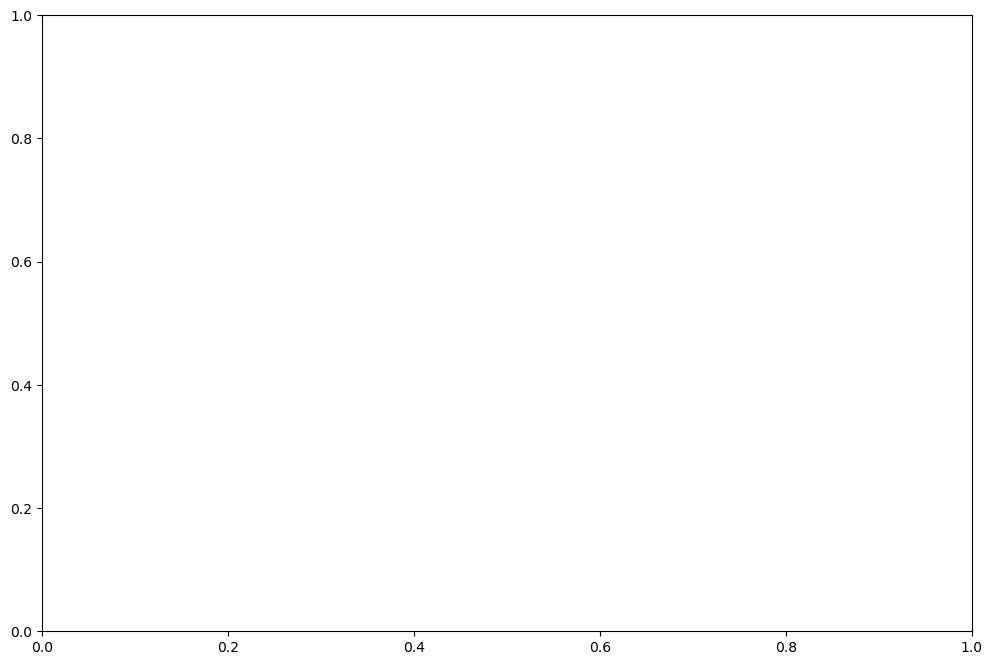

In [3]:
plt.figure(figsize = (12, 8))
plt.hist(emccd_d_vals, bins='auto', color = 'k')

In [9]:
import itertools

In [10]:
# [(i1, i2) for (i1, i2) in itertools.permutations(range(0, len(emccd_elems)), r=2)]

In [11]:
def get_DSH(i1, i2, elems=emccd_elems):
    """
    Get the dsh value for two indices
    """
    return calcDSH(*elems[i1], *elems[i2])

In [12]:
def split_into_groups(n, group_size):
    """
    Splits n into groups of approximately equal sizes.
    """
    groups = []
    for i in range(0, n, group_size):
        end = min(i + group_size - 1, n - 1)
        groups.append((i, end))
    return groups

if __name__ == "__main__":
    # Total size
    n = 101631
    group_size = 30000

    # Split into groups
    groups = split_into_groups(n, group_size)

    # Sequentially process each group
    results = []
    for start, end in groups:
        print(f"Processing group: {start} to {end}")
        result = process_group(start, end)
        results.append(result)

    # Combine or analyze results
    total_pairs = sum(results)
    print(f"Total pairs (n choose 2): {total_pairs}")

Processing group: 0 to 29999


NameError: name 'process_group' is not defined

In [23]:
for group_i, group_j in itertools.combinations(groups, 2):
    print(group_i, group_j)

(0, 29999) (30000, 59999)
(0, 29999) (60000, 89999)
(0, 29999) (90000, 101630)
(30000, 59999) (60000, 89999)
(30000, 59999) (90000, 101630)
(60000, 89999) (90000, 101630)


In [28]:
with multiprocessing.Pool(processes=4) as pool:
    results = np.array(list(pool.starmap(get_DSH, itertools.combinations(range(0, 10), r=2))))

In [ ]:
it_pairs = [(*impactor, *sb) for mc_sample in np.transpose(mc_orb_elements, axes=(1, 0, 2))[::downsampling_factor] 
            for (impactor, sb) in itertools.product(mc_sample, sbdb_orb_elements)]
it_pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
DSH_criteria_it_mc = np.array(list(tqdm(it_pool.starmap(calcDSH, it_pairs))))

In [ ]:
[result for result in results]

In [ ]:
DSH_criteria_ii = np.array([calcDSH(*i1, *i2) for (i1, i2) in 
                            itertools.permutations(impactor_orb_elements, r=2)]).reshape((len(impactor_orb_elements), len(impactor_orb_elements) - 1))

In [12]:
emccd_elems = np.c_[emccd_qs, emccd_es, emccd_is, emccd_nodes, emccd_omegas]
emccd_elems

array([[6.43424131e-01, 1.01792771e+00, 2.29990659e+01, 2.23080408e+02,
        2.52295854e+02],
       [3.01072363e-01, 5.74464806e-01, 3.63019662e+01, 4.30958167e+01,
        1.55291525e+02],
       [8.54489259e-01, 1.82327531e-01, 1.63713751e+02, 4.30928394e+01,
        8.40105848e+01],
       ...,
       [5.31402084e-01, 6.53591702e-01, 1.64734354e+01, 1.02531725e+02,
        2.81969381e+02],
       [3.70805624e-01, 8.16753721e-01, 1.37657184e+01, 1.02535126e+02,
        2.94381082e+02],
       [7.17583477e-01, 7.59456530e-01, 1.52628641e+02, 1.02506066e+02,
        2.51425779e+02]])

In [9]:
calcDSH(

NameError: name 'emccd' is not defined